# ECE 47300 Assignment 7 Exercise

Your Name:

### Objective: Build different transformer components and test them.

In [74]:
import numpy as np
import string
import time
import torch
import pdb
import math
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F
np.random.seed(124)

### NOTE: In this assignment, we will use the convention of having the batch dimension first so tensors will have shapes of `(N, L, D)` where `N` is the batch dimension, `L` is the max sequence length, and `D` is the feature dimension.
The default in PyTorch is for the sequence dimension to be first, i.e., `(L, N, D)` but most functions in PyTorch can be altered to make the batch dimension to be first by using `batch_first=True`, see for example the arguments for [`torch.nn.LSTM`](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).


# Exercise 1: Positional Encoder (20 points)
## Task 1: Implement Positional Encoder
The positional encoder is a simple function that takes a 3D tensor of shape (batch_size, sequence_length, encoding_size), i.e., `(N, L, D)`, and returns a 3D tensor of the same shape where positional encoding embedding has been added. The positional encoder is a function of the position of the token in the sequence. The positional encoder is defined as:

$$PE_{(pos,2i)} = \sin(pos/10000^{2i/d_{model}})$$

$$PE_{(pos,2i+1)} = \cos(pos/10000^{2i/d_{model}})$$

where $pos$ is the position and $i$ is the dimension. That is, each dimension of the positional encoding corresponds to a sinusoid. The wavelengths form a geometric progression from $2\pi$ to $10000 \cdot 2\pi$.

In practice, the positional encoding is added to the embedding vector. This is done by first creating a tensor of shape (1, sequence_length, d_model) and then adding it to the embedding vector. This ensures that the positional encoding is added to every element in the batch via broadcasting.

Hints:
- If done correctly the output of the code below should look like:
```
torch.Size([1, 4, 512])
False
input_pe: tensor([0.0100, 0.0200, 0.0300, 0.0400, 0.0500])
output_pe: tensor([0.2263, 1.4525, 0.6788, 1.9051, 1.1314])
input_pe: tensor([0.0100, 0.0200, 0.0300, 0.0400, 0.0500])
output_pe: tensor([1.0677, 0.9929, 1.5007, 1.4748, 1.9333])
input_pe: tensor([5.0800, 5.0900, 5.1000, 5.1100, 5.1200])
output_pe: tensor([115.9473, 115.1738, 116.3998, 115.6263, 116.8524])
```

In [75]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len = 80):
        super().__init__()
        self.d_model = d_model

        # create constant 'pe' matrix with values dependant on
        # pos and i
        pe = torch.zeros(max_seq_len, d_model)

        #### YOUR CODE HERE ####
        # Loop over the positions and the embedding dimensions
        # and calculate the positional encoding for each dimension
        # and position
        # If you want extra challenge, try to do this without loops.
        pos = torch.arange(0, max_seq_len)

        for i in range(d_model):
          if i % 2 == 0:
            pe[:, i] = torch.sin(pos / (10000)**((2 * i)/d_model))
          else:
            pe[:, i] = torch.cos(pos / (10000)**((2 * i)/d_model))

        #### END YOUR CODE ####

        pe = pe.unsqueeze(0)
        # Register this as something to keep when saving a model
        #  but that is not a learnable parameter
        self.register_buffer('pe', pe)


    def forward(self, x):
        # make embeddings relatively larger than pe
        x = x * math.sqrt(self.d_model)
        # add constant positional encoding to embedding
        seq_len = x.size(1)
        x = x + Variable(self.pe[:,:seq_len], requires_grad=False)
        return x

pos_enc = PositionalEncoder(512)
input_pe = torch.arange(1, 513)*0.01
input_pe = input_pe.repeat(1, 4, 1).float()

output_pe = pos_enc(input_pe)


# check the difference between the two embeddings
print(torch.equal(input_pe, output_pe)) # They should not be equal after adding positional encoding
print(f"input_pe: {input_pe[0, 0, 0:5]} \noutput_pe: {output_pe[0, 0, 0:5]}")
print(f"input_pe: {input_pe[0, 1, 0:5]} \noutput_pe: {output_pe[0, 1, 0:5]}")
print(f"input_pe: {input_pe[0, 2, -5:]} \noutput_pe: {output_pe[0, 2, -5:]}")

False
input_pe: tensor([0.0100, 0.0200, 0.0300, 0.0400, 0.0500]) 
output_pe: tensor([0.2263, 1.4525, 0.6788, 1.9051, 1.1314])
input_pe: tensor([0.0100, 0.0200, 0.0300, 0.0400, 0.0500]) 
output_pe: tensor([1.0677, 1.0222, 1.4808, 1.5285, 1.8931])
input_pe: tensor([5.0800, 5.0900, 5.1000, 5.1100, 5.1200]) 
output_pe: tensor([115.9473, 115.1735, 116.3998, 115.6261, 116.8524])


## Task 2: Visualize Positional Encodings
To understand positional encodings, we will generate an image of the positional encoding (encoding_size = 64) values over the hidden dimensionalities ( e.g. 1, 2, 7 and 16) and the position in a sequence. Below is the code to visualize the positional encoding for the hidden dimensions where sine and cosine waves with different wavelengths encode the position in the hidden dimensions. From the visualization, you will clearly see the sine and cosine waves with different wavelengths that encode the position in the hidden dimensions. As you will notice, the patterns between the hidden dimension 1 and 2 only differ in the starting angle. Also, the wavelength increases with the hidden dimensions.

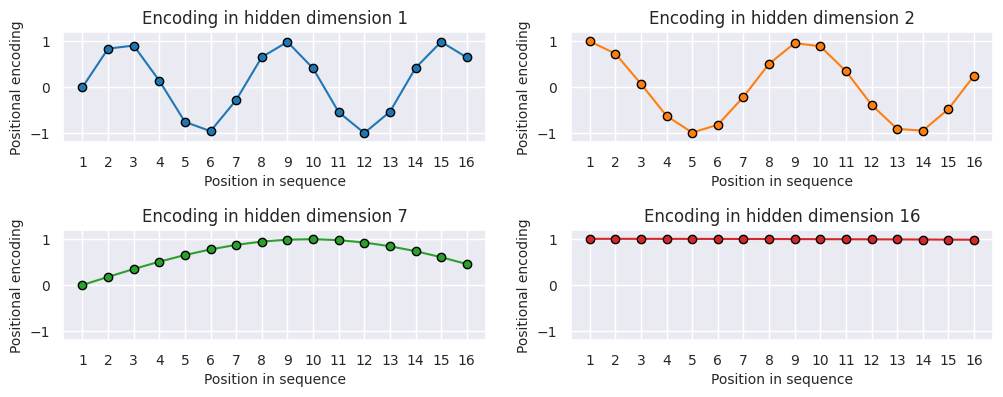

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_pe(pe_vals, hidden_dims):
    '''
    Inputs:
    pe_vals: A Numpy array of shape (L, D), the positional encoding values
    hidden_dims: A list containing the indices of hidden dimensions to visualize (1-indexed)
    '''
    sns.set_theme()
    fig, ax = plt.subplots(2, 2, figsize=(12,4))
    ax = [a for a_list in ax for a in a_list]
    for i in range(len(ax)):
        ax[i].plot(np.arange(1,17), pe_vals[:16, hidden_dims[i]-1], color=f'C{i}', \
                   marker="o", markersize=6, markeredgecolor="black")
        ax[i].set_title(f"Encoding in hidden dimension {hidden_dims[i]}")
        ax[i].set_xlabel("Position in sequence", fontsize=10)
        ax[i].set_ylabel("Positional encoding", fontsize=10)
        ax[i].set_xticks(np.arange(1,17))
        ax[i].tick_params(axis='both', which='major', labelsize=10)
        ax[i].tick_params(axis='both', which='minor', labelsize=8)
        ax[i].set_ylim(-1.2, 1.2)
    fig.subplots_adjust(hspace=0.8)
    sns.reset_orig()
    plt.show()

#### YOUR CODE HERE ####
# Define a positional encoder of encoding_size 64 and max_seq_len 32
# Use the `plot_pe` function to visualize the positional encoding (`pe`)
#   values for hidden dimensions 1, 2, 7 and 16
pos_enc = PositionalEncoder(64, max_seq_len=32)
input_pe = torch.arange(1, 33)*0.0001
input_pe = input_pe.repeat(1, 64, 1).view(1, -1, 64)
pe = pos_enc(input_pe.float())
pe = pe[0].detach().numpy()
plot_pe(pe, [1, 2, 7, 16])
#### END YOUR CODE ####

# Exercise 2: Scaled Dot-Product Attention (30 points)
In this exercise, you will implement a version of attention used in transformers. The key difference from the one described in class is that the attention scores (pre-softmax) are scaled by a factor of $\frac{1}{\sqrt{d_k}}$, where $d_k$ is the dimension of the keys (and the queries):
$$
A(Q,K,V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right) V
$$
where $Q \in \mathbb{R}^{L\times d_k}$, $K \in \mathbb{R}^{L \times d_k}$, and $V \in \mathbb{R}^{L \times d_v}$, where $d_v$ is the dimension of the values. The softmax is across the column dimension. The output of attention should be a matrix $A \in \mathbb{R}^{L \times d_v}$.

Additionally, we will implement a **batched version** of this that can be used for multiple sequences at the same time. To do this, you will need to use the following **batched** version(s) of matrix multiplication either [`torch.bmm`](https://pytorch.org/docs/stable/generated/torch.bmm.html) or [`torch.matmul`](https://pytorch.org/docs/stable/generated/torch.matmul.html) for both the $QK^T$ and the product of the attention matrix and $V$. We recommend that you use `torch.bmm` as it is more explicit.

Hint:
- You will need to transpose the matrices in the `k` tensor. Specifically, you will need to swap the last and second to last dimension so that it has shape (batch_size, d_k, seq_len). One way to do this is via the `transpose` function.
- If done correctly, the output should be like below:
```
Is shape of output correct? True
Is shape of att_values correct? True
Do attention values sum to 1? True
Output check (first):
tensor([-1.3709, -0.6827,  0.3234,  0.8677, -0.1474, -0.9653, -0.7344,  0.8126,
         0.1219,  0.3224,  0.6257, -0.0958, -0.1664, -0.0667, -0.2810,  0.3068,
        -0.7030, -0.6719,  0.4364, -1.0071,  0.3534,  0.3160,  0.0326, -0.7315,
        -0.5165])
Output check (last):
tensor([-0.2094,  1.3784,  0.2855, -0.1716,  0.1597, -0.6656,  0.3981, -0.9903,
        -0.6043, -0.6398,  0.0563, -1.5367, -0.0225, -0.8317,  0.0572,  0.2014,
         0.1324, -0.4563,  0.3832,  0.1051,  0.0653, -0.2076,  0.6225, -0.4946,
        -0.2935])
Is the implementation similar to Pytorch implementation? True
```

In [77]:
def attention(q, k, v):
    '''
    Inputs:
    q: query vector of shape (batch_size, seq_len, d_k)
    k: key vector of shape (batch_size, seq_len, d_k)
    v: value vector of shape (batch_size, seq_len, d_v)

    Returns:
    output: attention weighted sum of the value vectors
        of shape (batch_size, seq_len, d_v)
    att_values: attention weights of shape (batch_size, seq_len, seq_len)
    '''
    d_k = k.size(-1)
    assert d_k == q.size(-1), 'q and k should have the same dimensionality'
    d_v = v.size(-1)

    #### YOUR CODE HERE ####
    k = k.transpose(1, 2)
    divisor = d_k**0.5

    output = torch.bmm(q,k) / divisor

    att_values = torch.softmax(output, dim=-1)
    output = torch.bmm(att_values, v)
    #### END YOUR CODE ####

    return output, att_values

# test the attention function with some random values
torch.manual_seed(42)  # Do not change random seed
q = torch.randn(2, 5, 512)
k = torch.randn(2, 5, 512)
v = torch.randn(2, 5, 256)

output, att_values = attention(q, k, v)
print(f"Is shape of output correct? {output.shape == v.shape}")
print(f"Is shape of att_values correct? {att_values.shape == torch.Size([q.shape[0], q.shape[1], q.shape[1]])}")
print(f"Do attention values sum to 1? {torch.allclose(torch.sum(att_values, dim=-1), torch.ones(1))}")

# Last 25 values of last sample and last token
print(f"Output check (first): \n{output[0,0,:25]}")
print(f"Output check (last): \n{output[-1,-1,-25:]}")

# Compare with Pytorch Implementation
out = F.scaled_dot_product_attention(q,k,v)
print(f'Is the implementation similar to Pytorch implementation?'
      f' {torch.allclose(output, out, atol=1e-3, rtol=1)}')

Is shape of output correct? True
Is shape of att_values correct? True
Do attention values sum to 1? True
Output check (first): 
tensor([-1.3709, -0.6827,  0.3234,  0.8677, -0.1474, -0.9653, -0.7344,  0.8126,
         0.1219,  0.3224,  0.6257, -0.0958, -0.1664, -0.0667, -0.2810,  0.3068,
        -0.7030, -0.6719,  0.4364, -1.0071,  0.3534,  0.3160,  0.0326, -0.7315,
        -0.5165])
Output check (last): 
tensor([-0.2094,  1.3784,  0.2855, -0.1716,  0.1597, -0.6656,  0.3981, -0.9903,
        -0.6043, -0.6398,  0.0563, -1.5367, -0.0225, -0.8317,  0.0572,  0.2014,
         0.1324, -0.4563,  0.3832,  0.1051,  0.0653, -0.2076,  0.6225, -0.4946,
        -0.2935])
Is the implementation similar to Pytorch implementation? True


# Exercise 3: Attention modules (50 points)

## Task 1: Self-attention module
Implement a self-attention module that takes in `x` and computes `q`,`k`,`v` internally using 3 linear layers. Then, use your function from above to compute the output and attention and return it. The attention module should take as constructor parameters the `input_dim`, `key_dim`, and the `output_dim`.

Your output should look like the following:
```
input shape: torch.Size([4, 10, 512])
output shape: torch.Size([4, 10, 512])
Input:
tensor([-0.1988, -0.3060,  0.6383,  0.5713,  1.2769])
Output:
tensor([ 8.6836e-02, -4.1725e-02, -2.5798e-01, -9.6712e-02,  3.0022e-05],
       grad_fn=<SliceBackward0>)

Does the module exhibit permutation-equivaraince? True
The following two lines should be the same:
tensor([ 0.1849,  0.3706,  0.1488,  0.0898,  0.2528,  0.4277,  0.4572,  0.1172,
         0.0893, -0.2081], grad_fn=<SliceBackward0>)
tensor([ 0.1849,  0.3706,  0.1488,  0.0898,  0.2528,  0.4277,  0.4572,  0.1172,
         0.0893, -0.2081], grad_fn=<SliceBackward0>)
```

In [78]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim, key_dim, output_dim):
        super().__init__()
        #### YOUR CODE HERE ####
        # Define the linear layers to compute q, k, v (in order)
        self.q = nn.Linear(input_dim, key_dim)
        self.k = nn.Linear(input_dim, key_dim)
        self.v = nn.Linear(input_dim, output_dim)
        #### END YOUR CODE ####

    def forward(self, x):
        '''
        `x` has shape (batch_dim, sequence_length, input_dim) or (N, L, D_in)

        The output should have shape (batch_dim, sequence_length, output_dim) or (N, L, D_out).
        '''
        #### YOUR CODE HERE ####
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        output, att_values = attention(q, k, v)
        #### END YOUR CODE ####

        return output

# test the self-attention module with some random values
torch.manual_seed(48)
input_dim = 512
key_dim = 64
output_dim = 512
self_attn = SelfAttention(input_dim, key_dim, output_dim)
x = torch.randn(4, 10, 512)
output = self_attn(x)
print(f"input shape: {x.shape}")
print(f"output shape: {output.shape}")
print(f'Input: \n{x[0,0,:5]}\nOutput: \n{output[0,0,:5]}\n')

# For self-attention, let’s check the “permutation-equivariant” property,
# i.e., permute the input sequence and check if the output sequence is also permuted but otherwise the same.
# This is a nice sanity check that self-attention is working properly.
random_permutation = torch.randperm(x.size(1))
reverse_permutation = torch.zeros_like(random_permutation)
reverse_permutation[random_permutation] = torch.arange(len(random_permutation))
assert torch.all(x[:, random_permutation, :][:, reverse_permutation, :] == x), 'inverse is incorrect'

x_prime = x[:, random_permutation, :] # Permute input
output_prime = self_attn(x_prime)
output_prime_permuted = output_prime[:, reverse_permutation, :]  # Reverse permutation of output
print(f'Does the module exhibit permutation-equivaraince?'
      f' {torch.allclose(output, output_prime_permuted, atol=1e-5, rtol=1)}')
print(f'The following two lines should be the same:')
print(output[-1,-1,:10])
print(output_prime_permuted[-1,-1,:10])

input shape: torch.Size([4, 10, 512])
output shape: torch.Size([4, 10, 512])
Input: 
tensor([-0.1988, -0.3060,  0.6383,  0.5713,  1.2769])
Output: 
tensor([ 8.6836e-02, -4.1725e-02, -2.5798e-01, -9.6712e-02,  3.0022e-05],
       grad_fn=<SliceBackward0>)

Does the module exhibit permutation-equivaraince? True
The following two lines should be the same:
tensor([ 0.1849,  0.3706,  0.1488,  0.0898,  0.2528,  0.4277,  0.4572,  0.1172,
         0.0893, -0.2081], grad_fn=<SliceBackward0>)
tensor([ 0.1849,  0.3706,  0.1488,  0.0898,  0.2528,  0.4277,  0.4572,  0.1172,
         0.0893, -0.2081], grad_fn=<SliceBackward0>)


# Task 2: Cross Attention module
For cross attention, there will be an first input `x` that will correspond to the query and a second input `y` that will correspond to the keys and values. (In self-attention, `x` and `y` were equal).
This should be the same basic idea except that there is a linear layer to compute `q` from `x` and linear layers to compute `k` and `v` from `y`.

The output should look like the following:
```
input shape x and y: torch.Size([3, 10, 512]), torch.Size([3, 10, 256])
output shape: torch.Size([3, 10, 128])
x
tensor([-0.0385,  0.9773, -1.4370,  0.8719, -2.1034, -0.2877,  0.3034, -1.9151,
         1.1799,  0.6151])
y
tensor([-2.1565,  0.2397,  0.5872,  0.3950, -0.6114,  0.3489, -0.3467,  0.2792,
        -1.2541,  0.4053])
output
tensor([-0.1544,  0.0847,  0.2329,  0.0549, -0.1424,  0.0711,  0.0105, -0.2139,
        -0.0208, -0.1942], grad_fn=<SliceBackward0>)
```

In [79]:
class CrossAttention(nn.Module):
    def __init__(self, x_input_dim, y_input_dim, key_dim, output_dim):
        super().__init__()
        #### YOUR CODE HERE ####
        # Define the linear layers to compute q, k, v (in order)
        self.q = nn.Linear(x_input_dim, key_dim)
        self.k = nn.Linear(y_input_dim, key_dim)
        self.v = nn.Linear(y_input_dim, output_dim)

        #### END YOUR CODE ####

    def forward(self, x, y):
        '''
        `x` has shape (batch_dim, sequence_length, x_input_dim) or (N, L, x_D_in)
        `y` has shape (batch_dim, sequence_length, y_input_dim) or (N, L, y_D_in)

        The output should have shape (batch_dim, sequence_length, output_dim) or (N, L, D_out).
        '''
        #### YOUR CODE HERE ####
        q = self.q(x)
        k = self.k(y)
        v = self.v(y)

        output, att_values = attention(q, k, v)
        #### END YOUR CODE ####

        return output

# test the attention module with some random values
torch.manual_seed(14)
x_input_dim = 512
y_input_dim = 256
key_dim = 64
output_dim = 128
cross_attn = CrossAttention(x_input_dim, y_input_dim, key_dim, output_dim)
x = torch.randn(3, 10, x_input_dim)
y = torch.randn(3, 10, y_input_dim)
output = cross_attn(x, y)
print(f"input shape x and y: {x.shape}, {y.shape}")
print(f"output shape: {output.shape}")
print(f'x\n{x[0,0,:10]}')
print(f'y\n{y[0,0,:10]}')
print(f'output\n{output[0,0,:10]}')

input shape x and y: torch.Size([3, 10, 512]), torch.Size([3, 10, 256])
output shape: torch.Size([3, 10, 128])
x
tensor([-0.0385,  0.9773, -1.4370,  0.8719, -2.1034, -0.2877,  0.3034, -1.9151,
         1.1799,  0.6151])
y
tensor([-2.1565,  0.2397,  0.5872,  0.3950, -0.6114,  0.3489, -0.3467,  0.2792,
        -1.2541,  0.4053])
output
tensor([-0.1544,  0.0847,  0.2329,  0.0549, -0.1424,  0.0711,  0.0105, -0.2139,
        -0.0208, -0.1942], grad_fn=<SliceBackward0>)


## Task 3: Multi-headed self-attention module
Multi-headed self-attention merely passes the the input to each attention module, concatenates all the outputs, and then applies a linear layer to get the final output.
Implement multi-headed attention below.

Output should look like:
```
input shape: torch.Size([3, 10, 256])
output shape: torch.Size([3, 10, 32])
x
tensor([ 0.7195, -0.3636,  1.3771,  0.3482, -0.0604, -0.3034, -0.0698,  0.2131,
        -0.9736, -0.4651])
output
tensor([ 0.2290, -0.0350,  0.0918, -0.1069, -0.1679, -0.1939, -0.2167,  0.1841,
         0.0546,  0.1668], grad_fn=<SliceBackward0>)
```

In [80]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, attn_modules, final_output_dim):
        super().__init__()
        #### YOUR CODE HERE ####
        # 1) Save the attn_modules as a nn.ModuleList
        # 2) Setup a linear layer
        #   Hint for 2: Need to compute the concatenated dimensionality to
        #   setup linear layer by extracting the output dimension from each
        #   attention module.
        self.attn = nn.ModuleList(attn_modules)

        concat_dim = 0
        for i in self.attn:
          concat_dim += i.v.out_features

        self.final = nn.Linear(concat_dim, final_output_dim)

        #### END YOUR CODE ####

    def forward(self, x):
        #### YOUR CODE HERE ####
        # 1) Concatenate outputs of each self-attention module
        # 2) Apply final linear layer
        attn_outputs = []

        for i in self.attn:
          # print(i(x))
          attn_outputs.append(i(x))

        output = torch.cat(attn_outputs, dim=-1)
        output = self.final(output)
        #### END YOUR CODE ####

        return output

# test the multi-headed attention module with some random values
torch.manual_seed(10)
input_dim = 256
key_dim = 128
output_dim = 64
final_output_dim = 32
num_heads = 8
attn_modules = [SelfAttention(input_dim, key_dim, output_dim//num_heads) for _ in range(num_heads)]
multi_attn = MultiHeadedAttention(attn_modules, final_output_dim)

x = torch.randn(3, 10, input_dim)
output = multi_attn(x)
print(f"input shape: {x.shape}")
print(f"output shape: {output.shape}")
print(f'x\n{x[0,0,:10]}\noutput\n{output[0,0,:10]}')


input shape: torch.Size([3, 10, 256])
output shape: torch.Size([3, 10, 32])
x
tensor([ 0.7195, -0.3636,  1.3771,  0.3482, -0.0604, -0.3034, -0.0698,  0.2131,
        -0.9736, -0.4651])
output
tensor([ 0.2290, -0.0350,  0.0918, -0.1069, -0.1679, -0.1939, -0.2167,  0.1841,
         0.0546,  0.1668], grad_fn=<SliceBackward0>)


# (Optional, ungraded) Masked attention module
Try to implement the masked attention module for the decoder in a transformer.